In [1]:
from mpl_toolkits.basemap import Basemap

KeyError: 'PROJ_LIB'

* json how to: https://realpython.com/python-requests/
* USA source: https://covidtracking.com/us-daily/
* world source: https://www.trackcorona.live
* state pop source: https://www.census.gov/data/datasets/time-series/demo/popest/2010s-state-total.html#par_textimage_1873399417
* state abbreviation source: https://www.50states.com/abbreviations.htm
* county population source: https://www.census.gov/data/datasets/time-series/demo/popest/2010s-counties-total.html

https://www.colors.lol/

# Covid Data

# State

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests


Bad key "text.kerning_factor" on line 4 in
/opt/tljh/user/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
state_response = requests.get('https://covidtracking.com/api/states')

if state_response.status_code == 200:
    print('Success!')
else:
    print('An error has occurred')
    exit()


Success!


In [3]:
# Convert json to df
df_state = pd.json_normalize(state_response.json())

In [4]:
# Import states, abbreviations, state population
abbrevs = pd.read_csv('abbrevs.csv')
statepop = pd.read_csv('statepop.csv').iloc[5:].loc[:,('NAME','POPESTIMATE2019')].reset_index(drop = True)
state_pop = abbrevs.merge(statepop, left_on='State', right_on='NAME').loc[:,('NAME','Abbreviation','POPESTIMATE2019')]
state_pop.columns = ['state','abbrev','Pop2019']

In [5]:
class state_tracker:
    '''
    Returns covid stats, sorts by preference, and plots results
    '''
    def __init__(self, df, state_pop=state_pop, states_list=['MA', 'TX', 'OH', 'VT']):
        '''
        Selects appropriate columns and filters by state. Calculates percent deaths and percent hospitalized.
        
        % Deaths = Deaths/Positive
        % Hospitalized = Hospitalized/Positive
        '''
        # Select appropriate columns
        self.df = df[['state','positive','negative','hospitalizedCurrently','death','lastUpdateEt']]
        # Rename columns
        self.df.columns = ['State', 'Positive', 'Negative', 'Hospitalized', 'Deaths','Last Updated']
        self.all_us = self.df.sum()['Positive']
        # Replace NaN with 0
        self.df = self.df.fillna(0)
        
        self.state_pop = state_pop
        self.merged = self.df.merge(self.state_pop, left_on='State', right_on='abbrev')
        self.merged = self.merged.drop(['state','abbrev'], 1)
        
        df_select = self.merged
        # Percent death calculation
        df_select['Total Tested'] = df_select['Positive'] + df_select['Negative']
        df_select['% Pos of Tested'] = round((df_select['Positive']/df_select['Total Tested']) *100,2)
        df_select['% Deaths'] = round((df_select['Deaths']/df_select['Positive']) *100,2)
        df_select['% Hospitalized'] = round((df_select['Hospitalized']/df_select['Positive']) *100,2)
        df_select['Pos per 1000'] = round((df_select['Positive']/df_select['Pop2019']) *1000,2)
        df_select['% of US infected'] = round((df_select['Positive']/self.all_us) *100,2)
        # Select the states
        self.jnd = '|'.join(states_list)
        df_select = self.merged[self.merged['State'].str.contains(self.jnd)]
               
        self.df_select = pd.DataFrame(df_select)
    def all_df(self):
        '''
        Returns all states, select columns only.
        '''
        return self.merged
    
    def plotter(self, sort_by="% Hospitalized"):
        '''
        Plots the formatted df by the sort_by variable.
        '''
        df = self.df_select.sort_values(sort_by, ascending=False)
        sns.barplot(x = df.State, y = df[sort_by])
        if sort_by=="% Pos Positive":
            plt.title(f"{sort_by} per State")
            plt.ylim(0,1)
        else:
            plt.title(f"Number of {sort_by} results per State")
        
        return plt.show()
    
    def table(self, sort_by="% Hospitalized"):
        '''
        Returns the formatted df, but in a readable and prettified table
        
        Adds commas at 1000 values
        Adds % to the percent tables
        All values are in string
        '''
        df_select = self.df_select
        df_select = df_select.sort_values(sort_by, ascending = False)

        # Prettify output
        # Format percentages
        df_select['% Deaths'] = df_select['% Deaths'].apply(str) + "%"
        df_select['% Hospitalized'] = df_select['% Hospitalized'].apply(str) + "%"
        df_select['Pos per 1000'] = df_select['Pos per 1000'].apply(str) # + "%"
        df_select['% of US infected'] = df_select['% of US infected'].apply(str) + "%"
        df_select['% Pos of Tested'] = df_select['% Pos of Tested'].apply(str) + "%"

        # Round floats to just integers, use commas to separate
        columns = ['Positive', 'Negative', 'Hospitalized', 'Deaths', 'Pop2019']

        for col in columns:
            df_select[col] = pd.to_numeric(df_select[col]).apply(round)
            df_select[col] = df_select[col].apply(lambda x: "{:,}".format(x))
        df_select.columns = ['State', 'Positive-Cumulative', 'Negative-Cumulative', 'Hospitalized-Current', 'Deaths-Cumulative',
                             'Last Updated', 'Pop2019', 'Total Tested', '% Pos of Tested',
                             '% Deaths', '% Hospitalized', 'Pos per 1000', '% of US infected']
        self.table = df_select
        return(self.table)


In [6]:
yan = ['MA', 'TX', 'OH', 'VT', 'NY', 'NJ', 'CA']
chat = ['MA', 'TX', 'OH', 'VT']

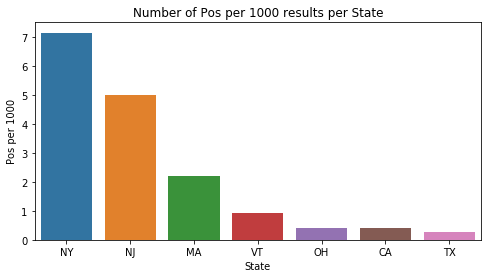

In [7]:
covid = state_tracker(df_state, states_list=yan)
plt.figure(figsize=(8,4))
covid.plotter(sort_by="Pos per 1000")


In [8]:
covid.table(sort_by = "Total Tested")

,State,Positive-Cumulative,Negative-Cumulative,Hospitalized-Current,Deaths-Cumulative,Last Updated,Pop2019,Total Tested,% Pos of Tested,% Deaths,% Hospitalized,Pos per 1000,% of US infected
33,NY,"138,863","201,195","17,493","5,489",4/06 00:00,"19,453,561",340058,40.84%,3.95%,12.6%,7.14,35.37%
4,CA,"15,865","115,364","2,611",374,4/07 18:00,"39,512,223",131229,12.09%,2.36%,16.46%,0.4,4.04%
30,NJ,"44,416","50,558","7,017","1,232",4/07 13:00,"8,882,190",94974,46.77%,2.77%,15.8%,5.0,11.31%
42,TX,"8,262","80,387","1,252",154,4/06 21:00,"28,995,881",88649,9.32%,1.86%,15.15%,0.28,2.1%
18,MA,"15,202","66,142",0,356,4/07 12:30,"6,892,503",81344,18.69%,2.34%,0.0%,2.21,3.87%
34,OH,"4,782","46,056",0,167,4/07 14:00,"11,689,100",50838,9.41%,3.49%,0.0%,0.41,1.22%
45,VT,575,"6,554",29,23,4/06 23:59,"623,989",7129,8.07%,4.0%,5.04%,0.92,0.15%


In [35]:
all_df.sum()

State               AKALARAZCACOCTDEFLGAHIIAIDILINKSKYLAMAMDMEMIMN...
Positive                                                       390638
Negative                                                      1650504
Hospitalized                                                    38990
Deaths                                                          12569
Last Updated        4/07 15:154/07 00:004/07 14:414/07 00:004/07 1...
Pop2019                                                     327533774
Total Tested                                                  2041142
% Pos of Tested                                                606.06
% Deaths                                                       126.62
% Hospitalized                                                  254.3
Pos per 1000                                                    44.94
% of US infected                                                99.49
dtype: object

In [40]:
all_df = covid.all_df()
all_pos = all_df.sum()["Positive"]
all_dead = all_df.sum()["Deaths"]
all_hosp = all_df.sum()["Hospitalized"]
all_tests = all_df.sum()['Total Tested']
frac_tests = (all_df.sum()['Total Tested']/all_df.sum()["Pop2019"]) * 1000

print("Totals in the USA to date:")
print(f'     Infected: {"{:,}".format(round(all_pos))}')
print(f'     Hospitalized: {"{:,}".format(round(all_hosp))}') 
print(f'     Deaths: {"{:,}".format(round(all_dead))}')
print(f'     Total tests: {"{:,}".format(round(all_tests))}')
print(f'     The US conducted {"{:,}".format(round(frac_tests))} tests per 1000 people')

Totals in the USA to date:
     Infected: 390,638
     Hospitalized: 38,990
     Deaths: 12,569
     Total tests: 2,041,142
     The US conducted 6 tests per 1000 people


# World

In [11]:
import time

In [12]:
world_response = requests.get('https://www.trackcorona.live/api/countries/')

if world_response.status_code == 200:
    print('Success!')
else:
    print('An error has occurred')
    exit()

Success!


In [13]:
# Convert json to df
df_world = pd.json_normalize(world_response.json()['data'])

In [14]:
world_pop_df = pd.read_csv("countries of the world.csv")

In [15]:
world_pop = world_pop_df.loc[:,("Country","Population")]

In [16]:
df_world = df_world.sort_values("location")

In [17]:
country_list = ['United States', 'Hungary', 'Jordan', 'Brazil', 
                'Germany','Mexico', 'China', 'Poland',
                'Italy', 'Spain','France','United Kingdom', 'Russia', "Iran"
               ]

In [18]:
def world_tracker(df, country_list=country_list, sort_by="Confirmed"):
    df = df.loc[:, ['location', 'confirmed','dead','recovered','updated']]
    df.columns = ["Location","Confirmed", "Dead", "Recovered", "Updated"]
    df["% of US"]=round((df["Confirmed"]/df.loc[df["Location"]=="United States", "Confirmed"].values[0]) * 100,2)
    df["% Share of World's Confirmed"] = round(df['Confirmed']/sum(df['Confirmed'])*100,2)
    df["% Share of World's Recovered"] = round(df['Recovered']/sum(df['Recovered'])*100,2)
    
    jnd = '|'.join(country_list)
    df = df[df['Location'].str.contains(jnd)]    
    df = df.sort_values(sort_by, ascending=False)
    
    return df

In [19]:
world = world_tracker(df_world, [""])

In [34]:
world = world.set_index("Location")
world_infected = sum(world['Confirmed'])
US_infected = world.loc["United States"]['Confirmed']
US_world_ratio = round((world.loc["United States"]['Confirmed']/world_infected) * 100, 2)

world_deaths = sum(world['Dead'])
US_deaths = world.loc["United States"]['Dead']
US_world_deaths = round((world.loc["United States"]['Dead']/world_deaths) * 100, 2)

world_recovered = sum(world['Recovered'])
US_recovered = world.loc["United States"]['Recovered']
US_world_recovered = round((world.loc["United States"]['Recovered']/world_recovered) * 100, 2)

print("Totals in the World to date:")
print(f"     World Confirmed: {world_infected:,}")
print(f"     US Confirmed: {US_infected:,}")
print(f"     {US_world_ratio:,}% of the world's confirmed are in the US.")
print("")
print(f"     World Deaths: {world_deaths:,}")
print(f"     US Deaths: {US_deaths:,}")
print(f"     {US_world_deaths:,}% of the world's deaths are in the US")
print("")
print(f"     World Recovered: {world_recovered:,}")
print(f"     US Recovered: {US_recovered:,}")
print(f"     {US_world_recovered:,}% of the world's recovered are in the US")

Totals in the World to date:
     World Confirmed: 1,423,217
     US Confirmed: 392,285
     27.56% of the world's confirmed are in the US.

     World Deaths: 81,832
     US Deaths: 12,627
     15.43% of the world's deaths are in the US

     World Recovered: 301,726
     US Recovered: 21,368
     7.08% of the world's recovered are in the US


In [21]:
world_tracker(df_world)

,Location,Confirmed,Dead,Recovered,Updated,% of US,% Share of World's Confirmed,% Share of World's Recovered
18,United States,392285,12627,21368,2020-04-07 22:40:04.998033+00:00,100.00,27.56,7.08
19,Spain,141942,14045,43208,2020-04-07 22:40:05.119040+00:00,36.18,9.97,14.32
20,Italy,135586,17127,24392,2020-04-07 22:40:05.194616+00:00,34.56,9.53,8.08
124,France,109069,10328,19337,2020-04-07 22:40:05.366623+00:00,27.80,7.66,6.41
123,Germany,107663,2016,36081,2020-04-07 22:40:05.254738+00:00,27.45,7.56,11.96
137,China,81740,3331,77167,2020-04-07 22:40:05.305643+00:00,20.84,5.74,25.58
21,Iran,62589,3872,27039,2020-04-07 22:40:05.413409+00:00,15.95,4.40,8.96
114,United Kingdom,55242,6159,135,2020-04-07 22:40:05.471304+00:00,14.08,3.88,0.04
116,Brazil,14018,686,127,2020-04-07 22:40:05.779405+00:00,3.57,0.98,0.04
43,Russia,7497,58,494,2020-04-07 22:40:06.103809+00:00,1.91,0.53,0.16


# Counties and Cities

## Import from Sources

In [23]:
city_response = requests.get('https://www.trackcorona.live/api/cities/')

if city_response.status_code == 200:
    print('Success!')
else:
    print('An error has occurred')
    exit()

Success!


In [24]:
# Convert json to df
df_citycounty = pd.json_normalize(city_response.json()['data'])

## Town Tracker

In [25]:
town_list = ['Corse','Heerlen']

In [26]:
def town_tracker (df, town_list=town_list, sort_by="confirmed"):
    df_city = df[~df['location'].str.contains(" County")]
    jnd = '|'.join(town_list)
    df_find = df_city[df_city['location'].str.contains(jnd)]
    df_find = df_find.sort_values(sort_by, ascending=False)
    return df_find

In [27]:
town_tracker(df_citycounty)

,location,latitude,longitude,confirmed,dead,recovered,updated
2451,Corse,42.039604,9.012893,250,32.0,113.0,2020-04-07 22:41:38.102947+00:00
7,Heerlen,50.888174,5.979499,84,NaN,NaN,2020-04-07 22:41:14.743111+00:00


## County Tracker

In [28]:
county_list = ['Summit County, Ohio', 
                'Cuyahoga County, Ohio', 
                'Suffolk County, Massachusetts',
                'Walker County, Texas',
                'Brooklyn', 'Queens', 'Manhattan', 'Bronx', 'Staten'] 

In [29]:
county_pop = pd.read_excel("countypop.xlsx", sheet_name=1)
county_pop = county_pop.iloc[1:].reset_index(drop=True)
county_pop['County'] = county_pop['County'].str[1:] # remove period from beginning of each county name

In [30]:
def county_tracker(df, county_pop = county_pop, county_list=county_list, sort_by="confirmed"):
    df_county = df[df['location'].str.contains(" County")].reset_index(drop=True)
    df_pop = df_county.merge(county_pop, left_on="location", right_on="County").drop("County", axis=1)
    df_pop['% confirmed'] = round((df_pop['confirmed']/df_pop['Population'])*100, 2)   
    
    df_pop = df_pop.sort_values(sort_by, ascending=False)

    columns = ['confirmed','dead','Population']       
    for col in columns:
        df_pop[col] = pd.to_numeric(df_pop[col]).apply(round)
        df_pop[col] = df_pop[col].apply(lambda x: "{:,}".format(x))

    df_pop['% confirmed'] = df_pop['% confirmed'].apply(str) + "%"
    
    jnd = '|'.join(county_list)
    df_find = df_pop[df_pop['location'].str.contains(jnd)]
    return df_find


In [31]:
county_tracker(df_citycounty)

,location,latitude,longitude,confirmed,dead,recovered,updated,Population,% confirmed
209,"Queens County, New York",40.728224,-73.794852,"23,133",948,NaN,2020-04-07 22:40:30.283745+00:00,"2,253,858",1.03%
214,"Bronx County, New York",40.837049,-73.865430,"14,327",709,NaN,2020-04-07 22:40:30.283745+00:00,"1,418,207",1.01%
2208,"Suffolk County, Massachusetts",42.352287,-71.050423,"2,929",33,NaN,2020-04-07 22:40:30.283745+00:00,"803,907",0.36%
973,"Cuyahoga County, Ohio",41.433923,-81.675820,871,15,NaN,2020-04-07 22:40:30.283745+00:00,"1,235,072",0.07%
1260,"Summit County, Ohio",41.091899,-81.559643,189,10,NaN,2020-04-07 22:40:30.283745+00:00,"541,013",0.03%
2291,"Walker County, Texas",30.681539,-95.645795,10,0,NaN,2020-04-07 22:40:30.283745+00:00,"72,971",0.01%
